In [1]:
import os
import numpy as np
from Bio import SeqIO

In [2]:
def ucitaj_edit_rastojanja(putanja_do_fajla):
    edit_rastojanja = {}
    proteini_nazivi = []
    with open(putanja_do_fajla, 'r') as file:
        linije = file.readlines()
        for linija in linije:
            protein1, protein2, razdaljina = linija.strip().split(', ')
            edit_rastojanja[(protein1.strip(), protein2.strip())] = int(razdaljina)

            if protein1 not in proteini_nazivi:
                proteini_nazivi.append(protein1.strip())
            if protein2 not in proteini_nazivi:
                proteini_nazivi.append(protein2.strip())
                
    # Konvertovanje rastojanja u matricu
    matrica_rastojanja = np.zeros((len(proteini_nazivi), len(proteini_nazivi)))
    for i, protein1 in enumerate(proteini_nazivi):
        for j, protein2 in enumerate(proteini_nazivi):
            if (protein1, protein2) in edit_rastojanja:
                matrica_rastojanja[i, j] = edit_rastojanja[(protein1, protein2)]
            elif (protein2, protein1) in edit_rastojanja:
                matrica_rastojanja[i, j] = edit_rastojanja[(protein2, protein1)]

    return matrica_rastojanja, proteini_nazivi

In [3]:
putanja_do_fajla = "edit_rastojanja.txt"
matrica_rastojanja, proteini_nazivi = ucitaj_edit_rastojanja(putanja_do_fajla)

In [4]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
def klasterovanje(edit_rastojanja, broj_klastera):
    klasterovanje = AgglomerativeClustering(n_clusters=broj_klastera, linkage='average', metric='precomputed')
    klasteri = klasterovanje.fit_predict(edit_rastojanja)
    return klasteri

In [6]:
def nacrtaj_dendogram(edit_rastojanja, proteini_nazivi):
    # Izracunavanje hijerarhijskog klastera
    linkage_matrix = linkage(matrica_rastojanja, method='average')
    
    # Iscrtavanje dendrograma
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=list(proteini_nazivi), leaf_font_size=8)
    plt.title('Dendrogram klastera nukleotidnih sekvenci')
    plt.xlabel('Proteini')
    plt.ylabel('Udaljenost')
    plt.show()

/var/folders/qk/20038v213xqdyl7bkp4fcs_h0000gn/T/ipykernel_1321/1476488248.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrica_rastojanja, method='average')


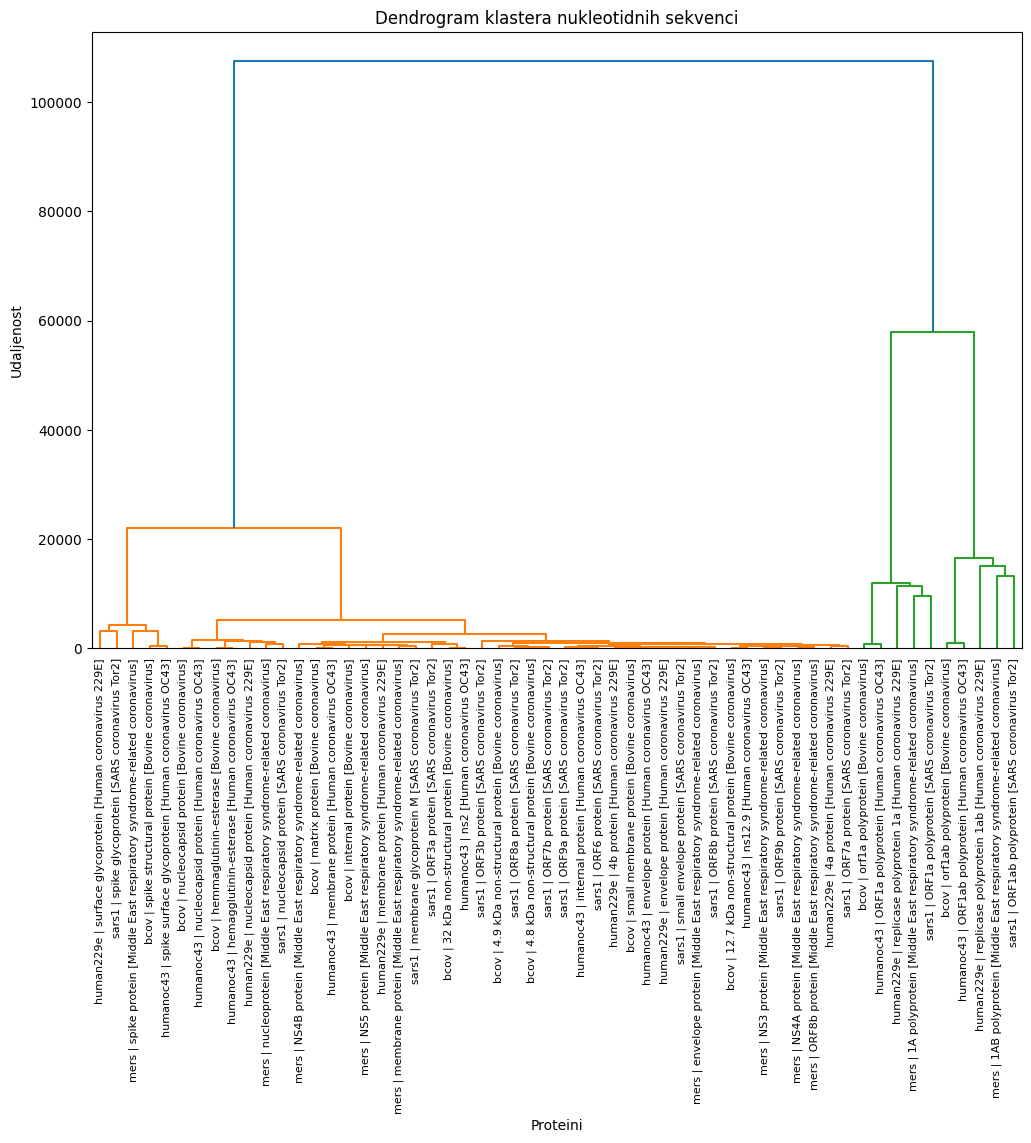

In [7]:
nacrtaj_dendogram(matrica_rastojanja, proteini_nazivi)

In [8]:
broj_klastera = 3
klasteri = klasterovanje(matrica_rastojanja, broj_klastera)

In [9]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import IFrame

In [10]:
def vizualizacija_klastera(pca_matrica, klasteri, proteini_nazivi, paleta_boja):
    fig = go.Figure(data=go.Scatter())
    
    fig.add_trace(go.Scatter(
        x = pca_matrica[:, 0],
        y = pca_matrica[:, 1],
        mode = 'markers',
        marker = dict(color=klasteri, colorscale=paleta_boja, size=8),
        hovertext = proteini_nazivi
    ))

    # dodavanje opisa
    fig.add_annotation(
        x = 0.5,
        y = 1.05,
        text = "*prevucite misem preko '&#9679;' da biste videli naziv proteina*",
        showarrow = False,
        font = dict(size=12),
        xref = "paper",
        yref = "paper"
    )
    
    # podesavanje naslova i oznaka
    fig.update_layout(title="Vizuelizacija klastera", xaxis_title="PCA 1", yaxis_title="PCA 2")
    
    # cuvanje i prikaz 
    fig.write_html("klasteri.html")
    return IFrame(src='./klasteri.html', width=800, height=600)

In [11]:
def vizualizacija_povrsinskih_proteina(pca_matrica, klasteri, proteini_nazivi, boja):
    plt.figure(figsize=(8, 6))
    
    for i in range(len(pca_matrica)):
        if 'spike' in proteini_nazivi[i] or 'surface' in proteini_nazivi[i]:
            x = pca_matrica[i, 0]
            y = pca_matrica[i, 1]
            plt.scatter(x, y, color=boja, s=50, alpha=0.7)

            # Automatsko odredivanje polozaja teksta
            horizontalno_poravnanje = 'right' if x > -1500 else 'left'
            plt.text(x, y, proteini_nazivi[i], fontsize=9, ha=horizontalno_poravnanje)
            
    plt.title('Vizuelizacija povrsinskih proteina nakon klasterovanja')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.show()

In [12]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [13]:
paleta = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c']).colors
# primenjujemo PCA na matricu rastojanja kako bismo mogli da vizuelizujemo nase podatke
pca = PCA(n_components=2)
pca_matrica = pca.fit_transform(matrica_rastojanja)

for i in range(len(proteini_nazivi)):
    proteini_nazivi[i] = proteini_nazivi[i].split(' | ')[1]

vizualizacija_klastera(pca_matrica, klasteri, proteini_nazivi, paleta)

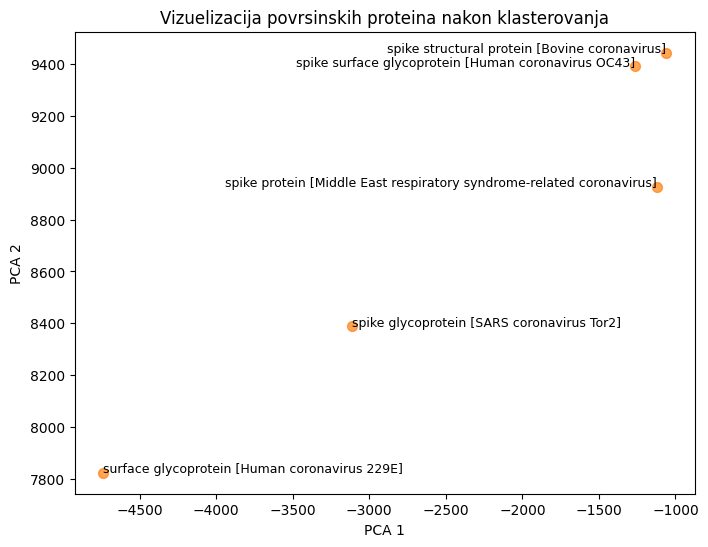

In [14]:
vizualizacija_povrsinskih_proteina(pca_matrica, klasteri, proteini_nazivi, paleta[1])

Treba napomenuti da je ovaj raspored prikazan na matrici na koju je primenjena PCA, čime je smanjena dimenzija sa 56x56.

In [15]:
nazivi_i_pozicije = []
for (i, naziv) in enumerate(proteini_nazivi):
    if 'spike' in naziv or 'surface' in naziv:
        nazivi_i_pozicije.append((i, naziv))

rastojanja_povrsinskih_proteina = []
for (i, naziv1) in nazivi_i_pozicije:
    for (j, naziv2) in nazivi_i_pozicije:
        if i != j:
            rastojanja_povrsinskih_proteina.append((naziv1, naziv2, matrica_rastojanja[i][j]))

matrica = [[0] * (len(nazivi_i_pozicije)) for _ in range(len(nazivi_i_pozicije))]

nazivi_povrsinskih_proteina = []
i = 0
for (_, naziv) in nazivi_i_pozicije:
    nazivi_povrsinskih_proteina.append((i, naziv))
    i += 1

matrica[0][0] = 0
for (naziv1, naziv2, rastojanje) in rastojanja_povrsinskih_proteina:
    i = 0
    j = 0
    for (pozicija, naziv) in nazivi_povrsinskih_proteina:
        if naziv1 == naziv:
            i = pozicija
        if naziv2 == naziv:
            j = pozicija
        
    if i == j:
        matrica[i][j] = 0
    
    matrica[i][j] = rastojanje

In [16]:
import pandas as pd
from IPython.display import display, HTML

In [17]:
df = pd.DataFrame(matrica, index = [i[1] for i in nazivi_povrsinskih_proteina], columns = [i[1] for i in nazivi_povrsinskih_proteina])

html_code = """
<div style="text-align: center; font-weight: bold; color: green; font-size: 16px">
    Edit rastojanja povrsinskih proteina
</div>
"""
display(HTML(html_code))

df

,spike structural protein [Bovine coronavirus],surface glycoprotein [Human coronavirus 229E],spike surface glycoprotein [Human coronavirus OC43],spike protein [Middle East respiratory syndrome-related coronavirus],spike glycoprotein [SARS coronavirus Tor2]
spike structural protein [Bovine coronavirus],0.0,1930.0,276.0,1916.0,1879.0
surface glycoprotein [Human coronavirus 229E],1930.0,0.0,1925.0,1952.0,1799.0
spike surface glycoprotein [Human coronavirus OC43],276.0,1925.0,0.0,1887.0,1867.0
spike protein [Middle East respiratory syndrome-related coronavirus],1916.0,1952.0,1887.0,0.0,1869.0
spike glycoprotein [SARS coronavirus Tor2],1879.0,1799.0,1867.0,1869.0,0.0


Kako bismo bolje i preciznije mogli da uporedimo sa p-adicnim rastojanjem, na rastojanja izmedju povrsinskih proteina cemo sada primeniti PCA i time dimenziju smanjiti sa matrice 5x5 sto je isto uradjeno i kod p-adicnog rastojanja.

In [25]:
def vizualizacija_povrsinskih_proteina(pca_matrica, proteini_nazivi, boja):
    plt.figure(figsize=(8, 6))
    
    for i in range(len(pca_matrica)):
        if 'spike' in proteini_nazivi[i] or 'surface' in proteini_nazivi[i]:
            x = pca_matrica[i, 0]
            y = pca_matrica[i, 1]
            plt.scatter(x, y, color=boja, s=50, alpha=0.7)

            # Automatsko odredivanje polozaja teksta
            horizontalno_poravnanje = 'right' if x > -200 else 'left'
            vertikalno_poravnanje = 'top' if y < -30 else 'bottom' 
            plt.text(x, y, proteini_nazivi[i], fontsize=9, ha=horizontalno_poravnanje, va=vertikalno_poravnanje)
            
    plt.title('Vizuelizacija povrsinskih proteina koristeci edit rastojanje')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.show()

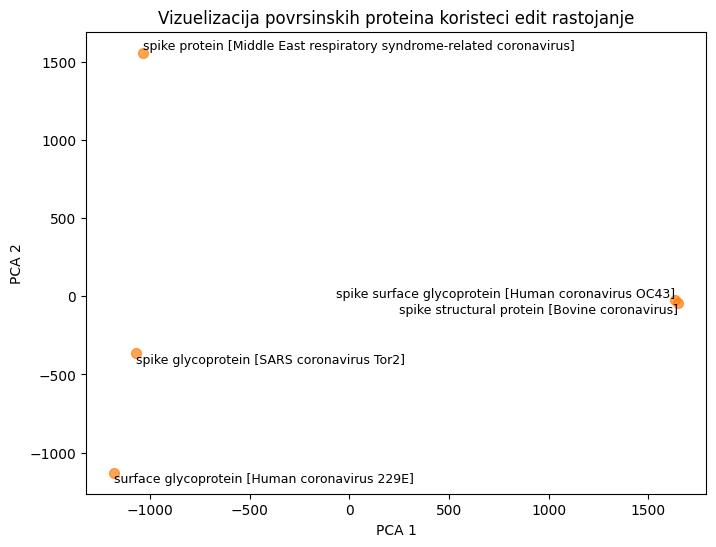

In [26]:
pca = PCA(n_components=2)
pca_matrica = pca.fit_transform(matrica)
vizualizacija_povrsinskih_proteina(pca_matrica, [i[1] for i in nazivi_povrsinskih_proteina], paleta[1])